<a href="https://colab.research.google.com/github/AtrCheema/Miscellaneous_DL_Tutorials/blob/master/many_to_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

This notebook explains how to build a simple RNN/LSTM for a simple timeseries prediction problem using Tensorflow and Keras APIs. The implementation is `many-to-one`, where we feed a sequence at one time-step and the NN predicts one value.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.python.ops.rnn import dynamic_rnn
from tensorflow.nn.rnn_cell import BasicRNNCell
from tensorflow.python.keras.layers import LSTMCell, SimpleRNNCell, LSTM, SimpleRNN, RNN, Dense 

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.metrics import mean_squared_error

# this function cleans the tensorflow graph
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [0]:
# for input data preparation, we use the function present in github repository.
import os
if 'Miscellaneous_DL_Tutorials' not in os.listdir():
    !git clone https://github.com/AtrCheema/Miscellaneous_DL_Tutorials.git

from Miscellaneous_DL_Tutorials.rnn_data_preparation import batch_generator

## Input data preparation

In [0]:

#just a random function that we want our RNN/LSTM to learn
# It can be made as complex as possible
def time_series(t1,t2, t3, t4):
    return   np.cos(t1) * np.sin(t2) / 3 + 2 * np.sin(t3*5) + np.cos(t4) * 2.5
  
n = 10000
cycles = 1000

a = np.cos(np.linspace(0, 0+cycles, n)) +1
b = np.sin(np.linspace(0, 0+cycles, n)) +1
y = time_series(a,b,b,b)


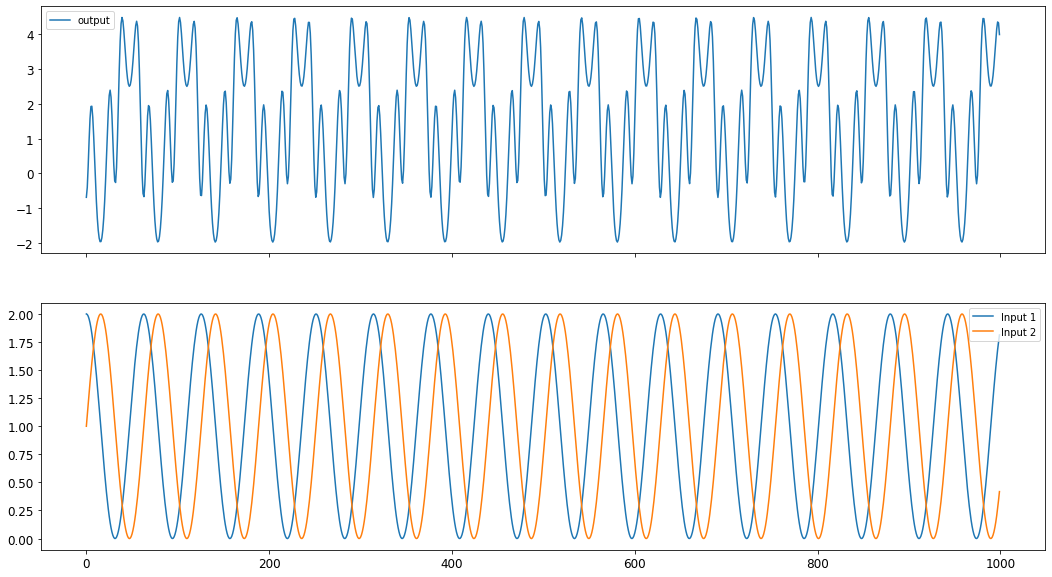

In [4]:
p_vals = 1000
fig, (ax,ax2) = plt.subplots(2, sharex='all')
fig.set_figheight(10)
fig.set_figwidth(18)
ax.plot(y[0:p_vals], label='output')
ax.legend()

ax2.plot(a[0:p_vals], label='Input 1')
ax2.plot(b[0:p_vals], label='Input 2')
ax2.legend()


plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler

train_x_scaler = MinMaxScaler(feature_range=(0, 1))
train_y_scaler = MinMaxScaler(feature_range=(0, 1))
val_x_scaler = MinMaxScaler(feature_range=(0, 1))
val_y_scaler = MinMaxScaler(feature_range=(0, 1))

# arrange data such that first 2 columns are input and last column is output
data = np.stack([a,b, y], axis=1)

_lookback = 40  # sequence length
input_features = data.shape[1]-1
output_features = 1
_batch_size = 64
input_stepsize = 1
train_st = 0
train_end = 7000
val_st = 7000
val_end = data.shape[0]
t_plus_ith_val = 1 # which value to predict in future, e.g if input is 11,12,13,14 and default value of this variable means we
                  # want to predict 15, setting value equal to 3 means we want to predict 17.
batch_size = _batch_size
n_steps = _lookback

train_args = {'lookback': _lookback,
            'in_features': input_features,
            'out_features': output_features,
            'min_ind': train_st,
            'max_ind': train_end,
            'future_y_val': t_plus_ith_val,
            'step': input_stepsize,
            'norm': {'x_scaler': train_x_scaler, 'y_scaler': train_y_scaler},
            'trim_last_batch':True}
train_generator = batch_generator(data, _batch_size, train_args, verbose=False) 
train_gen = train_generator.many_to_one()

val_args = {'lookback': _lookback,
            'in_features': input_features,
            'out_features': output_features,
            'min_ind': val_st,
            'max_ind': val_end,
            'future_y_val': t_plus_ith_val,
            'step': input_stepsize,
            'norm': {'x_scaler': val_x_scaler, 'y_scaler': val_y_scaler},
            'trim_last_batch':True}
val_generator = batch_generator(data,_batch_size, val_args, verbose=False ) 
val_gen = val_generator.many_to_one()

### Building NN Model



In [0]:
reset_graph()


n_inputs = input_features #1
n_outputs = output_features 
n_neurons = 100   # in RNN/LSTM
learning_rate = 0.00001

x_ph = tf.placeholder(tf.float32, [batch_size, n_steps, n_inputs])
y_ph = tf.placeholder(tf.float32, [batch_size, n_outputs])
 

In [14]:
# Using keras_layer is the most easiest one, however, sometimes we may want to make some changes in cell, so than we use `keras_cell`.
# 'dynamic_rnn' means, we don't want anython from Keras and implementation is pure in Tensorflow. Deprecated
# method can be RNN or LSTM

implementation = 'keras_cell'
method = 'RNN'    # LSTM/RNN

if implementation == 'keras_layer':
    if method == 'RNN':
        rnn_outputs = SimpleRNN(units=n_neurons, activation='relu')(x_ph)
    else:
        rnn_outputs = LSTM(units=n_neurons, activation=tf.nn.relu)(x_ph)

elif implementation == 'keras_cell':
    if method == 'RNN':
        cell = SimpleRNNCell(units=n_neurons, activation='relu')
    else:
        cell = LSTMCell(units=n_neurons, activation=tf.nn.relu)
    
    rnn_outputs = RNN(cell)(x_ph)

elif implementation == 'dynamic_rnn':
    if method == 'RNN':
        cell = BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    else:
        cell = LSTMCell(units=n_neurons, activation=tf.nn.relu)

    rnn_outputs, states = dynamic_rnn(cell, x_ph, dtype=tf.float32)
    rnn_outputs = tf.reshape(rnn_outputs[:,-1,:], [-1, n_neurons])

print(rnn_outputs.shape, 'rnn_outputs shape')

(64, 100) rnn_outputs shape


In [15]:

if implementation == 'dynamic_rnn': 
  dense_outputs = tf.layers.dense(rnn_outputs, n_outputs) 
else:
    dense_outputs = Dense(n_outputs)(rnn_outputs)
  
predictions = tf.reshape(dense_outputs, [-1,  n_outputs])
print(predictions.shape, 'shape outputs')

(64, 1) shape outputs


In [0]:
loss = tf.reduce_mean(tf.square(predictions - y_ph))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
X_batch, y_batch = next(train_gen)
X_batch.shape, y_batch.shape


Number of batches are 108 


((64, 40, 2), (64, 1))

### Training the model
The first loop is for epochs and second loop is for batches.

In [19]:
n_epochs = 100
n_batches = 108
test_iterations = 20
tot_loss = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        bat_loss = []
        for bat in range(n_batches):
            X_batch, y_batch = next(train_gen)
             
            _, mse = sess.run([training_op, loss], feed_dict={x_ph: X_batch, y_ph: y_batch})
            bat_loss.append(mse)
        epoch_loss = np.mean(bat_loss)
        tot_loss.append(epoch_loss)
        print(epoch, "\tMSE:", epoch_loss)
            
    
    # check the performance of model on validation data
    test_y_pred = np.full((test_iterations*batch_size), np.nan)
    test_y_true = np.full((test_iterations*batch_size), np.nan)
    test_x = np.full((test_iterations*batch_size), np.nan)
    st = 0
    en = batch_size
    for i in range(test_iterations):
        val_x_batch, val_y_batch = next(val_gen)
        y_pred = sess.run(predictions, feed_dict={x_ph: val_x_batch})
        test_y_pred[st:en] = y_pred.reshape(-1,)
        test_y_true[st:en] = val_y_batch.reshape(-1,)
        #test_x[st:en] = val_x_batch
        st += batch_size
        en += _batch_size
    
    #saver.save(sess, "./my_time_series_model")

0 	MSE: 0.22364627
1 	MSE: 0.20302545
2 	MSE: 0.18304786
3 	MSE: 0.16083142
4 	MSE: 0.13097079
5 	MSE: 0.056644637
6 	MSE: 0.030264962
7 	MSE: 0.026450453
8 	MSE: 0.023645164
9 	MSE: 0.020849077
10 	MSE: 0.018828558
11 	MSE: 0.017358588
12 	MSE: 0.01612059
13 	MSE: 0.0150343105
14 	MSE: 0.0140327355
15 	MSE: 0.013085488
16 	MSE: 0.012165883
17 	MSE: 0.011077691
18 	MSE: 0.009938512
19 	MSE: 0.0089742225
20 	MSE: 0.008042666
21 	MSE: 0.00708001
22 	MSE: 0.006170285
23 	MSE: 0.0053196014
24 	MSE: 0.0044966657
25 	MSE: 0.0037342112
26 	MSE: 0.0030463913
27 	MSE: 0.0023853318
28 	MSE: 0.0018767071
29 	MSE: 0.0014935188
30 	MSE: 0.001099533
31 	MSE: 0.0007405658
32 	MSE: 0.00050076534
33 	MSE: 0.0003605716
34 	MSE: 0.00026342648
35 	MSE: 0.00018679361
36 	MSE: 0.00012989131
37 	MSE: 9.69695e-05
38 	MSE: 7.525614e-05
39 	MSE: 5.9160528e-05
40 	MSE: 4.6893576e-05
41 	MSE: 3.744582e-05
42 	MSE: 3.016373e-05
43 	MSE: 2.4517882e-05
44 	MSE: 1.9915095e-05
45 	MSE: 1.6164047e-05
46 	MSE: 1.3200938

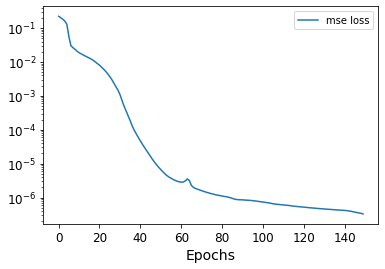

In [20]:
fig, ax = plt.subplots(1)
ax.semilogy(tot_loss, label='mse loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.show()

In [0]:
# we need to rescale the inputs and outputs to their original limits 
val_y_batch = val_y_scaler.inverse_transform(test_y_true.reshape(-1,output_features))
y_pred = val_y_scaler.inverse_transform(test_y_pred.reshape(-1,output_features))


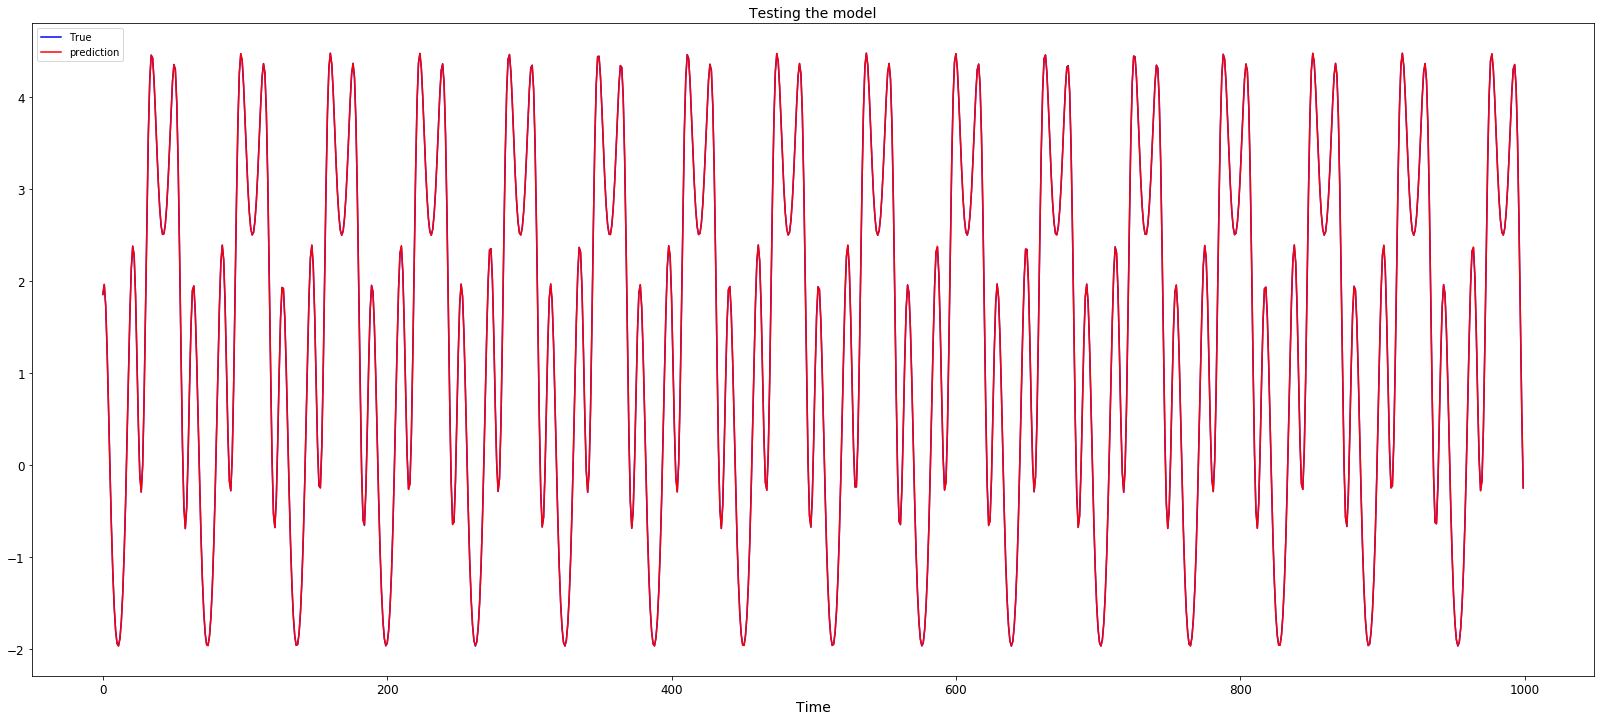

In [22]:
p_vals = 1000
fig, ax = plt.subplots(1)
fig.set_figwidth(28)
fig.set_figheight(12)
ax.set_title("Testing the model", fontsize=14)
ax.plot(val_y_batch[0:p_vals], "b", markersize=4, label="True") 
ax.plot(y_pred[0:p_vals], "r", markersize=4, label="prediction")
ax.legend(loc="upper left")
ax.set_xlabel("Time")

plt.show()

## Using Keras
We can implement the whole above thing in pure Keras which is built on top of Tensorflow. It is easier to implement in Keras as compared to Tensorflow. We don't need to define placeholders and for loops explicitly.

In [0]:

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


In [0]:
model = Sequential()
model.add(LSTM(n_neurons, activation='relu', input_shape=(_lookback, input_features)))
model.add(Dense(output_features))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=108,
                            epochs=50,
                            #validation_data=val_gen,
                            #validation_steps=195
                            )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
shape of x data: (6921, 40, 1) 
shape of y data: (6960, 1)
.
39 values are skipped from start and 40 values are skipped from end in output array

potential samples are 6921

residue is 9 

Actual samples are 6912

Number of batches are 108 





500/500 [==============================] - 24s 49ms/step - loss: 0.2043
Epoch 2/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0788
Epoch 3/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0448
Epoch 4/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0311
Epoch 5/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0256
Epoch 6/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0226
Epoch 7/50
500/500 [==============================] - 24s 47ms/step - loss: 0.0203
Epoch 8/50
500/500 [==============================] - 24s 48ms/step - loss: 0

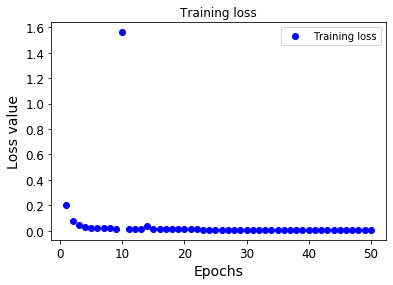

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Training loss')
plt.legend()
plt.show()

In [0]:
val_batches = 45
true_arg = np.full((val_batches*_batch_size, output_features), np.nan)
pred_arg = np.full((val_batches*_batch_size, output_features), np.nan)
st = 0
en = _batch_size
for tb in range(val_batches):
    val_x, val_y = next(val_gen)
    val_prediction = model.predict(val_x, 1, verbose=True)
    val_prediction = val_y_scaler.inverse_transform(val_prediction)
    true            = val_y_scaler.inverse_transform(val_y)
    true_arg[st:en,:] = true[:,:]
    pred_arg[st:en,:] = val_prediction[:,:]
    st += _batch_size
    en += _batch_size

64/64 [==============================] - 0s 3ms/step


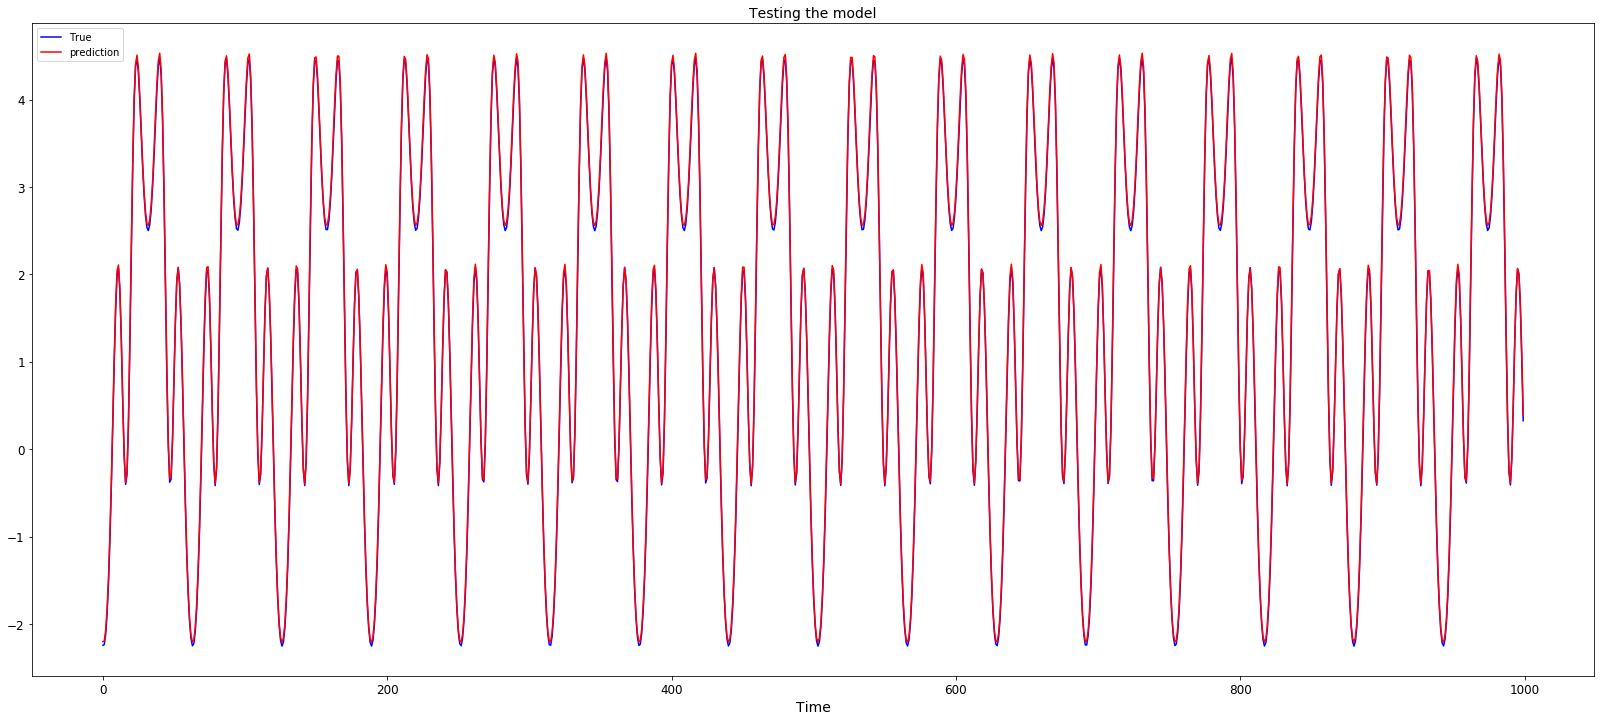

In [0]:

p_vals = 1000
fig, ax = plt.subplots(1)
fig.set_figwidth(28)
fig.set_figheight(12)
ax.set_title("Testing the model", fontsize=14)
ax.plot(true_arg[0:p_vals], "b", markersize=4, label="True") 
ax.plot(pred_arg[0:p_vals], "r", markersize=4, label="prediction")
ax.legend(loc="upper left")
ax.set_xlabel("Time")

plt.show()

#### Note
We can also use `CuDNNLSTM` which is designed to specifically run on GPUs and is faster than simple LSTM. However, `LSTM` also uses GPU but CuDNNLSTM is more faster than LSTM.